# CNN - CIFAR10 - Data Augmentation

In [1]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

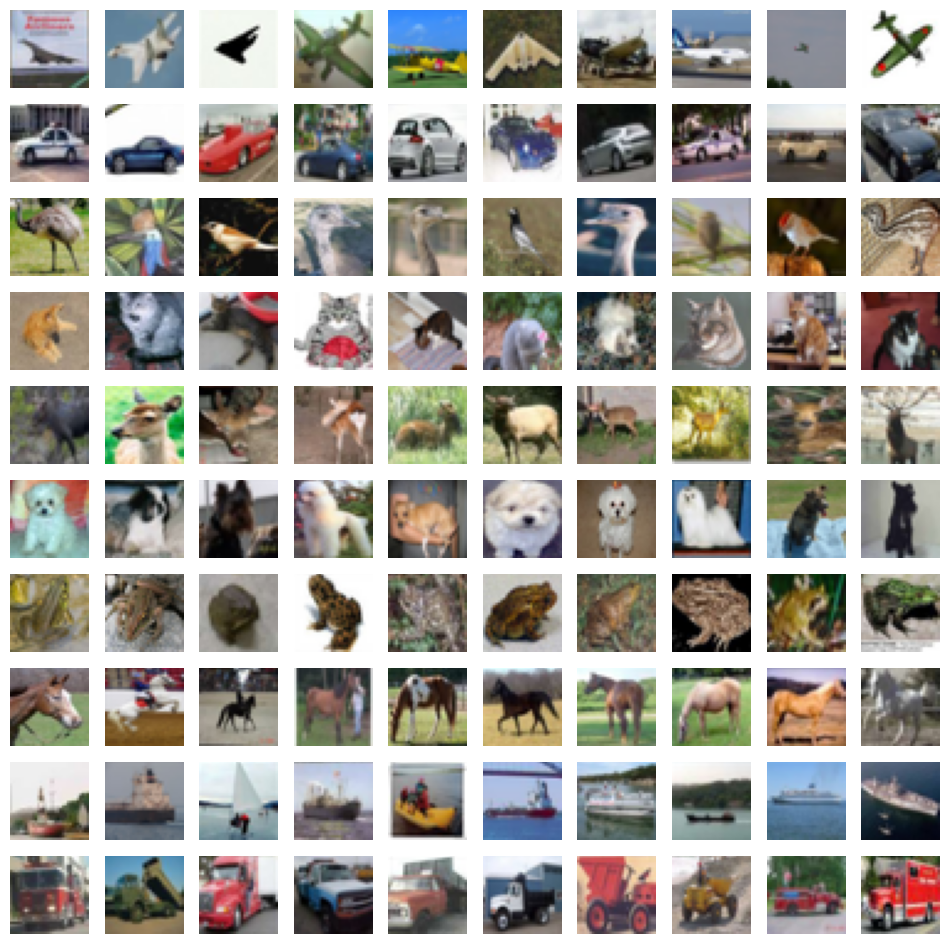

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [3]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [5]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [10]:
from tensorflow import keras

cnn = keras.Sequential()
cnn.add(keras.layers.Input(shape=(32, 32, 3)))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same'))
cnn.add(keras.layers.Activation(keras.activations.relu))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same'))
cnn.add(keras.layers.Activation(keras.activations.relu))
cnn.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
cnn.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1, 1), padding='same'))
cnn.add(keras.layers.Activation(keras.activations.relu))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(units=n_classes))
cnn.add(keras.layers.Activation("softmax"))
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_3 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                      

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [11]:
E = 10
B = 128

cnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)
log = cnn.fit(
    x=X_train,
    y=Y_train,
    batch_size=B,
    epochs=E,
    validation_data=(X_test, Y_test),
)

Epoch 1/10
391/391 [==============================] - 6s 8ms/step - loss: 1.5200 - accuracy: 0.4581 - val_loss: 1.2911 - val_accuracy: 0.5492
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 1.1284 - accuracy: 0.6062 - val_loss: 1.0742 - val_accuracy: 0.6206
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 0.9540 - accuracy: 0.6692 - val_loss: 0.9647 - val_accuracy: 0.6648
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 0.8503 - accuracy: 0.7079 - val_loss: 0.8914 - val_accuracy: 0.6914
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 0.7716 - accuracy: 0.7353 - val_loss: 0.8755 - val_accuracy: 0.7000
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 0.7187 - accuracy: 0.7545 - val_loss: 0.8877 - val_accuracy: 0.6901
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 0.6694 - accuracy: 0.7708 - val_loss: 0.8667 - val_accuracy: 0.7028
Epoch 

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

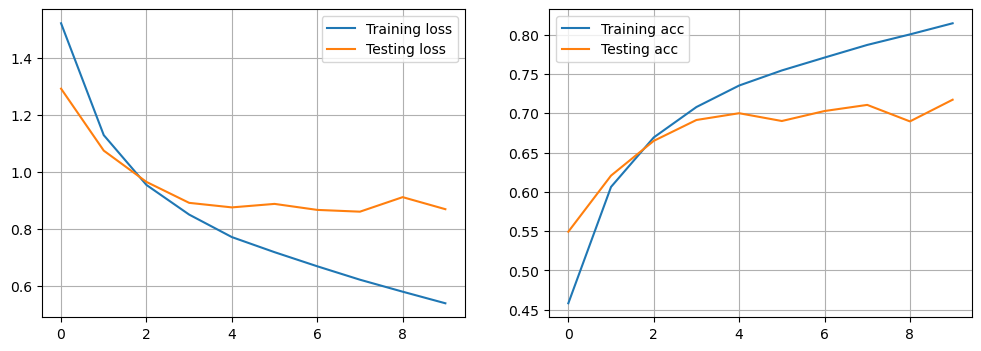

In [12]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [13]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8692244291305542
Test accuracy: 0.717199981212616


### Confusion matrix
We can call the `predict()` function to get the predicted classes. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

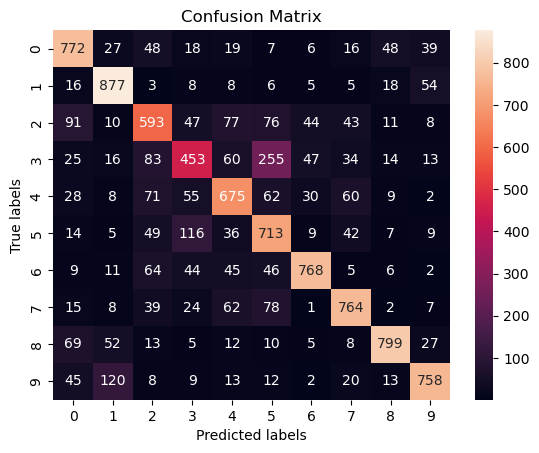

In [14]:
import seaborn as sns

pred = cnn.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(y_test, pred)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipelines, one for train set, one for test set
gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    shear_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
batches_train = gen.flow(x=X_train, y=Y_train, batch_size=B)
batches_test = gen.flow(x=X_test, y=Y_test, batch_size=B)

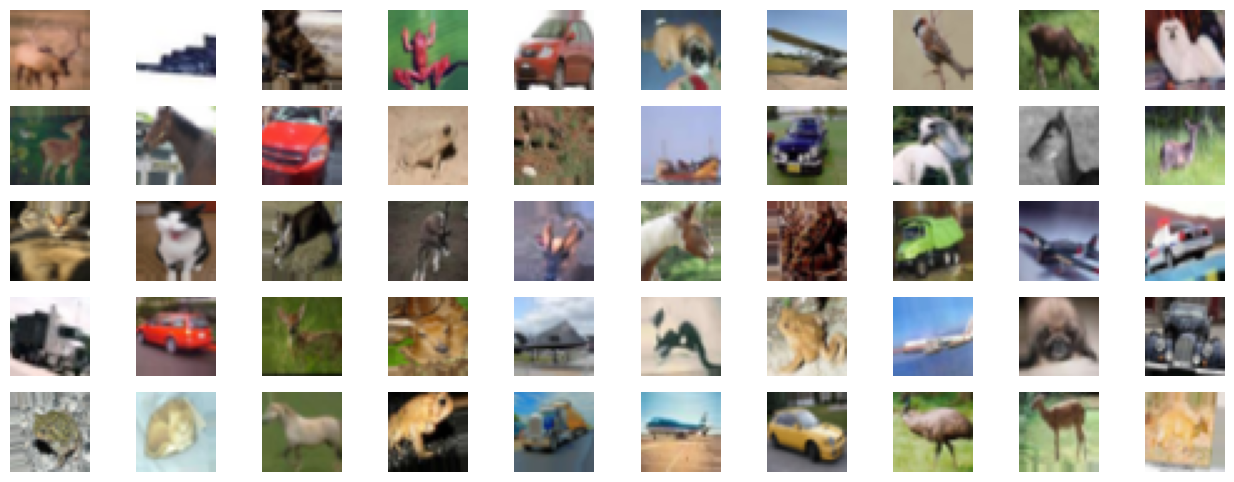

In [16]:
# Display some samples
sample_batch = batches_train.next()[0]
n_samples = 50
row_size = 10
fig, axs = plt.subplots(nrows=n_samples//row_size, ncols=row_size, figsize=(16,6))
for i in range(n_samples):
    row = i // row_size
    col = i % row_size
    axs[row, col].imshow(sample_batch[i,:,:,:])
    axs[row, col].axis("off")
plt.show()

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above. 

In [17]:
# Compile and train the network
cnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)
log = cnn.fit(
    batches_train,
    steps_per_epoch=50000//B,
    epochs=E,
    validation_data=batches_test,
    validation_steps=10000//B,
    use_multiprocessing=False # I get an error message otherwise
)

Epoch 1/10
390/390 [==============================] - 14s 36ms/step - loss: 0.9220 - accuracy: 0.6803 - val_loss: 0.9412 - val_accuracy: 0.6734
Epoch 2/10
390/390 [==============================] - 14s 36ms/step - loss: 0.8800 - accuracy: 0.6896 - val_loss: 0.9247 - val_accuracy: 0.6782
Epoch 3/10
390/390 [==============================] - 13s 35ms/step - loss: 0.8577 - accuracy: 0.7039 - val_loss: 0.9064 - val_accuracy: 0.6894
Epoch 4/10
390/390 [==============================] - 13s 34ms/step - loss: 0.8391 - accuracy: 0.7089 - val_loss: 0.8960 - val_accuracy: 0.6895
Epoch 5/10
390/390 [==============================] - 13s 34ms/step - loss: 0.8259 - accuracy: 0.7141 - val_loss: 0.8779 - val_accuracy: 0.6965
Epoch 6/10
390/390 [==============================] - 13s 34ms/step - loss: 0.8138 - accuracy: 0.7193 - val_loss: 0.9070 - val_accuracy: 0.6899
Epoch 7/10
390/390 [==============================] - 13s 34ms/step - loss: 0.7972 - accuracy: 0.7240 - val_loss: 0.8733 - val_accuracy:

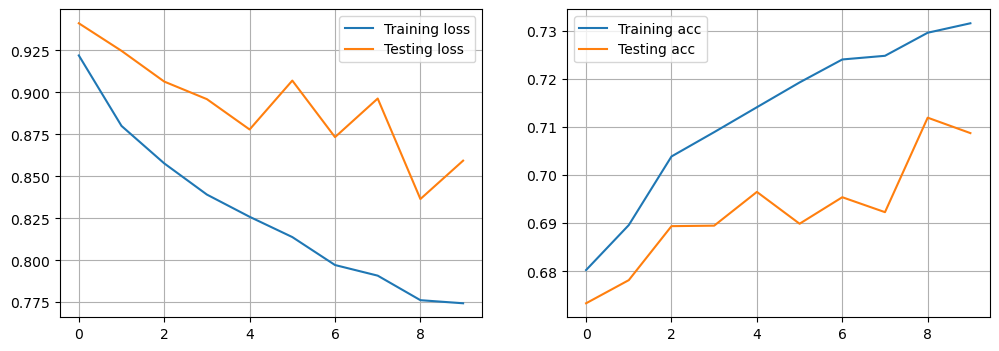

In [18]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [19]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8605414032936096
Test accuracy: 0.7253000140190125


In [20]:
# Define the data augmentation pipelines, one for train set, one for test set
E = 15
gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)
batches_train = gen.flow(x=X_train, y=Y_train, batch_size=B)
batches_test = gen.flow(x=X_test, y=Y_test, batch_size=B)

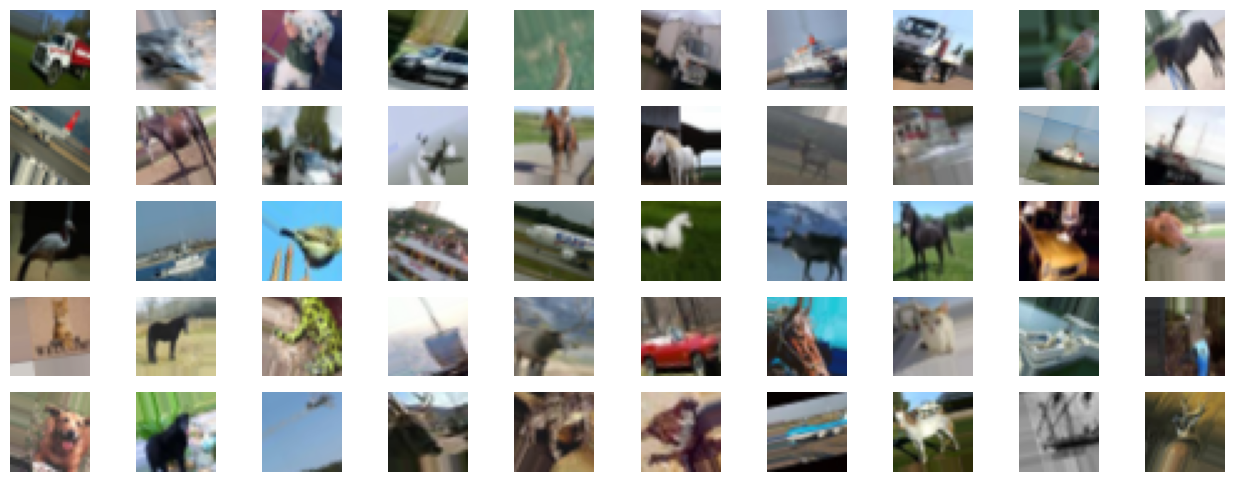

In [21]:
# Display some samples
sample_batch = batches_train.next()[0]
n_samples = 50
row_size = 10
fig, axs = plt.subplots(nrows=n_samples//row_size, ncols=row_size, figsize=(16,6))
for i in range(n_samples):
    row = i // row_size
    col = i % row_size
    axs[row, col].imshow(sample_batch[i,:,:,:])
    axs[row, col].axis("off")
plt.show()

In [22]:
# Compile and train the network
cnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)
log = cnn.fit(
    batches_train,
    steps_per_epoch=50000//B,
    epochs=E,
    validation_data=batches_test,
    validation_steps=10000//B,
    use_multiprocessing=False # I get an error message otherwise
)

Epoch 1/15
390/390 [==============================] - 14s 36ms/step - loss: 1.1522 - accuracy: 0.5988 - val_loss: 1.1475 - val_accuracy: 0.5944
Epoch 2/15
390/390 [==============================] - 14s 35ms/step - loss: 1.1113 - accuracy: 0.6097 - val_loss: 1.1082 - val_accuracy: 0.6123
Epoch 3/15
390/390 [==============================] - 14s 35ms/step - loss: 1.0888 - accuracy: 0.6201 - val_loss: 1.0915 - val_accuracy: 0.6188
Epoch 4/15
390/390 [==============================] - 13s 34ms/step - loss: 1.0754 - accuracy: 0.6224 - val_loss: 1.0710 - val_accuracy: 0.6236
Epoch 5/15
390/390 [==============================] - 13s 34ms/step - loss: 1.0632 - accuracy: 0.6288 - val_loss: 1.1202 - val_accuracy: 0.6083
Epoch 6/15
390/390 [==============================] - 13s 34ms/step - loss: 1.0576 - accuracy: 0.6316 - val_loss: 1.0688 - val_accuracy: 0.6246
Epoch 7/15
390/390 [==============================] - 13s 34ms/step - loss: 1.0429 - accuracy: 0.6367 - val_loss: 1.0561 - val_accuracy:

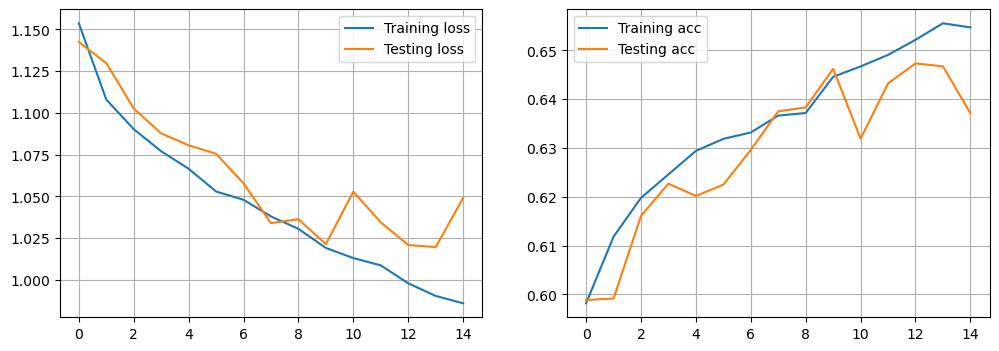

In [43]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [44]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.9201616048812866
Test accuracy: 0.6958000063896179


### Table of results

Describe your data augmentation strategies here.

| CNN | Architecture description | Acc. train | Acc. test |
|-----|--------------------------|------------|-----------|
|  No DA | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.8145  | 0.7172 |
|  With DA v1 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.7316  | 0.7087 |
|  With DA v2 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.6546  | 0.6517 |

Generally data augmentation really works well against overfitting. In both cases we can see no more overfitting and could even try training the model a bit longer. However especially in the second version we introduce probably a bit too much variability and therefore the model takes more time to learn. The second version looks the best.

# Exercise 2 Visualisation of activations

Implement a code to visualise all the filters at a given layer. Hints : use subplots to have a grid of images, use for loops to avoid code repetition.

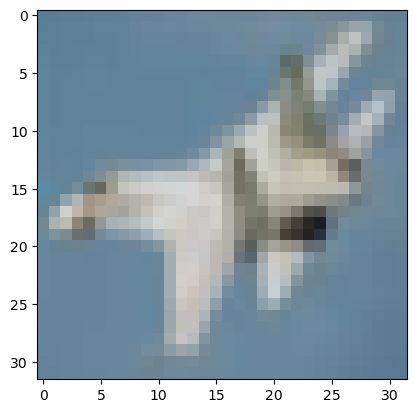

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32), dtype=tf.float32, name=None), name='conv2d_5/BiasAdd:0', description="created by layer 'conv2d_5'")


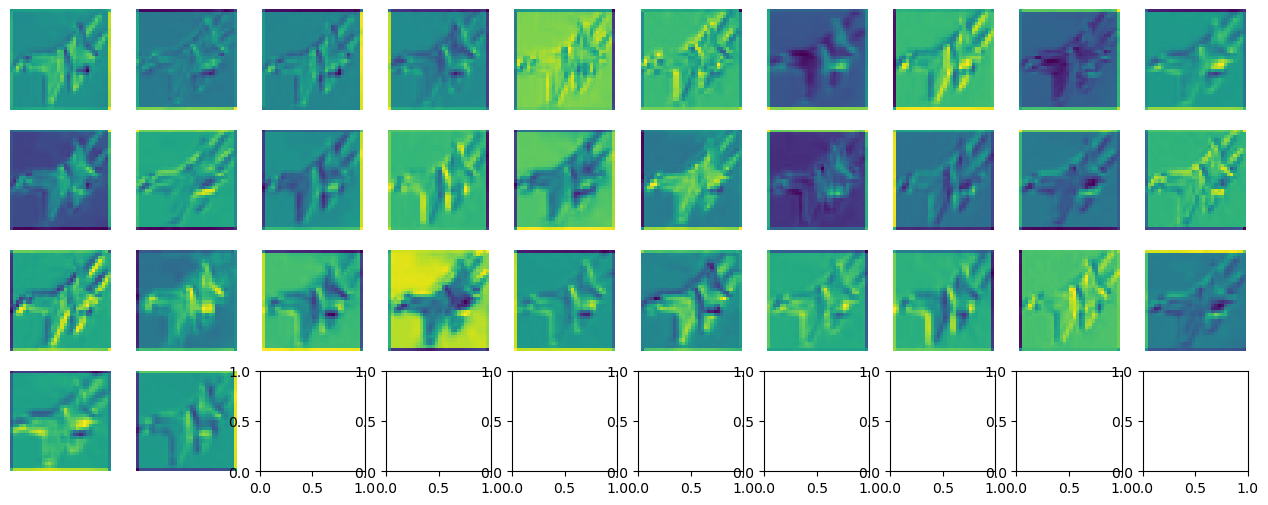

In [23]:
#Test image
test_img = X_test[10]
plt.imshow(test_img)
plt.show()
test_img = test_img.reshape(1, 32, 32, 3)



def plot_activations(outputs, base_model, test_img):
    activation_model = keras.models.Model(inputs=base_model.input, outputs=outputs)
    activation = activation_model.predict(test_img)
    n_filters = activation.shape[3]
    row_size = 10
    fig, axs = plt.subplots(nrows=n_filters//row_size+1, ncols=row_size, figsize=(16,6))
    for i in range(n_filters):
        row = i // row_size
        col = i % row_size
        axs[row, col].imshow(activation[0,:,:,i])
        axs[row, col].axis("off")
    plt.show()

outputs_first_layer = cnn.layers[0].output
print(outputs_first_layer)
plot_activations(outputs=outputs_first_layer, base_model=cnn, test_img=test_img)

For a given input image (e.g. X_train[12]), visualise the different activations maps of your network : outputs of CONV, RELU, MAXP. Comment on what you see.

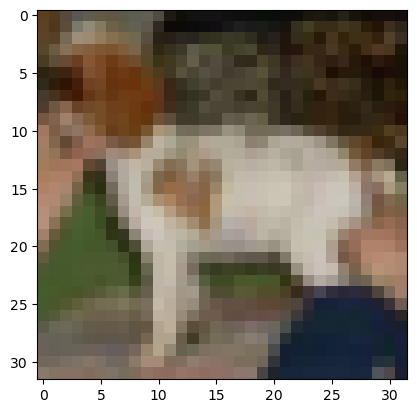

----------------------------------------------------------------------------------------------------
Activations layer 0 - conv2d_5


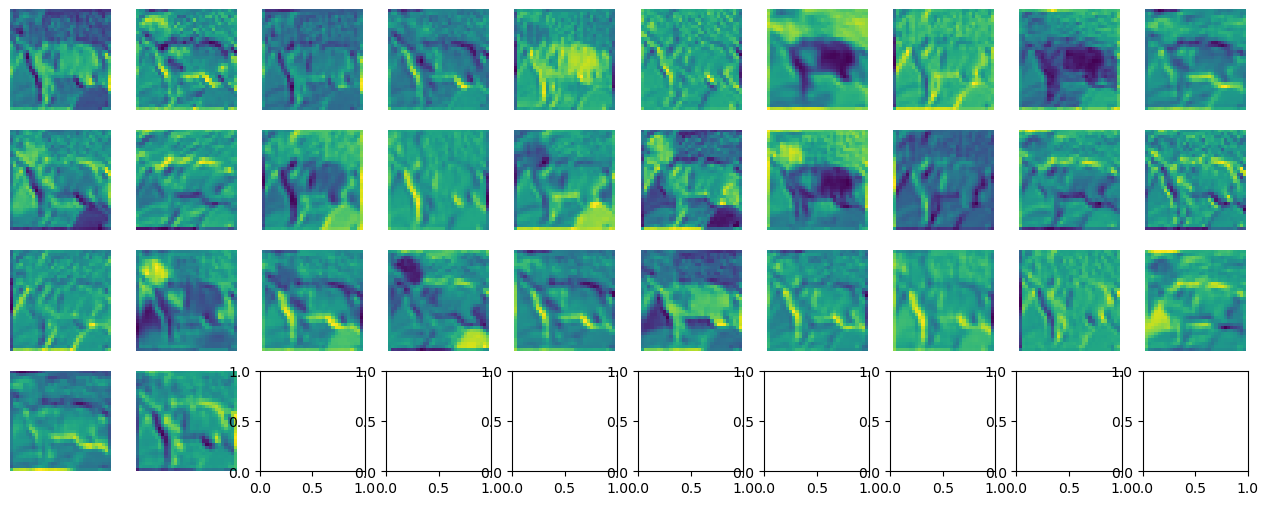

----------------------------------------------------------------------------------------------------
Activations layer 1 - activation_2


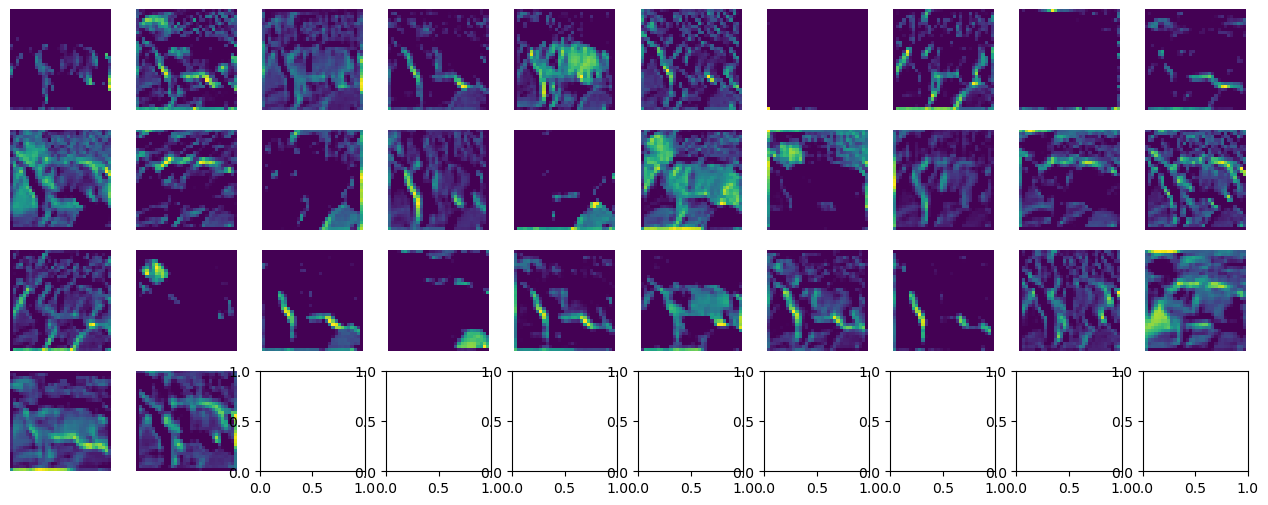

----------------------------------------------------------------------------------------------------
Activations layer 2 - conv2d_6


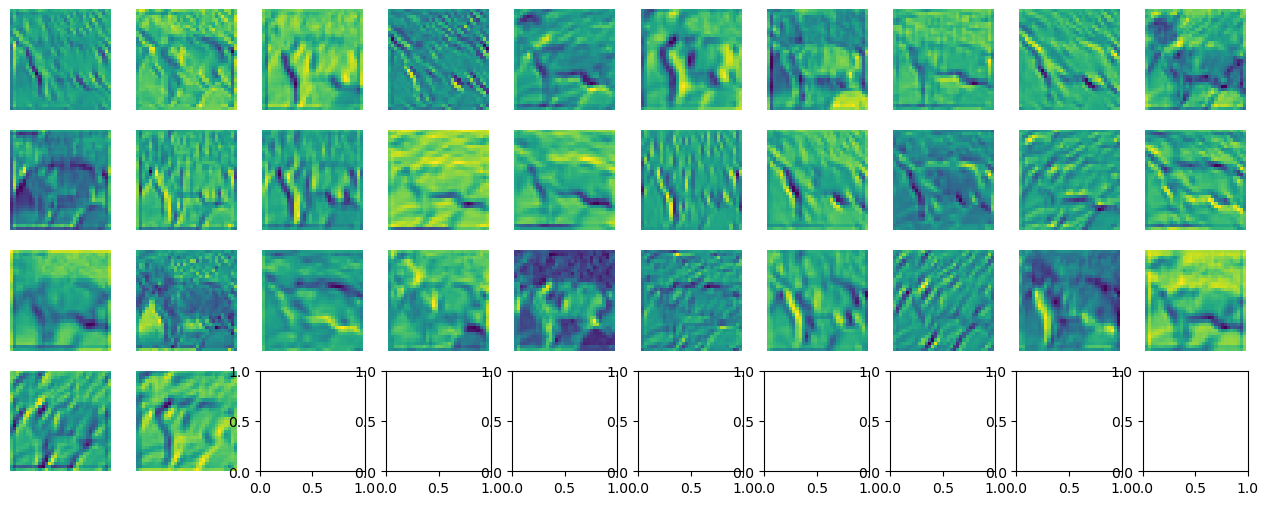

----------------------------------------------------------------------------------------------------
Activations layer 3 - activation_3


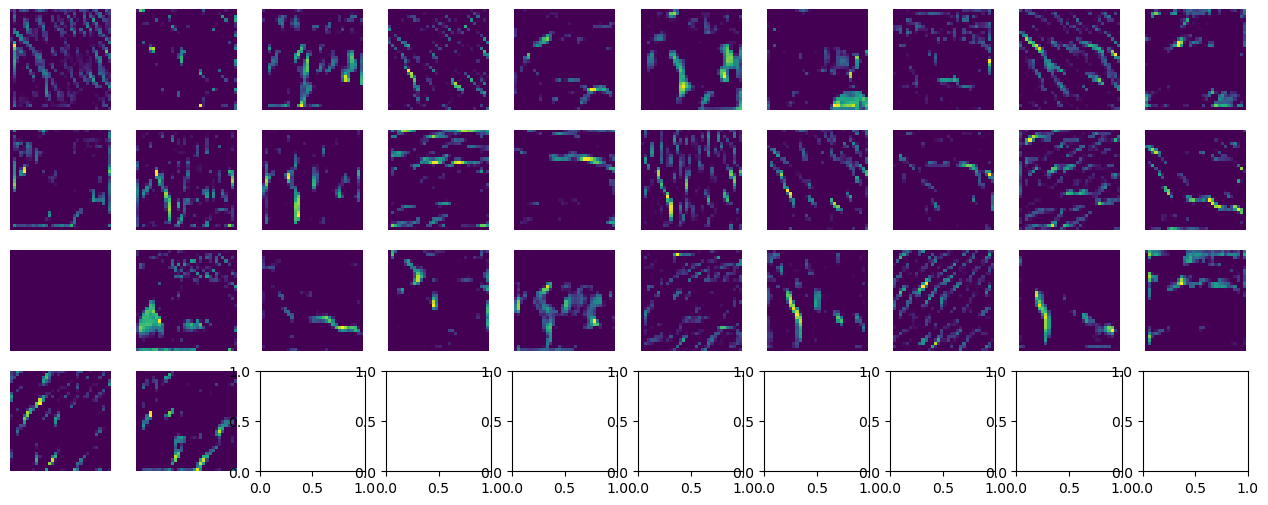

----------------------------------------------------------------------------------------------------
Activations layer 4 - max_pooling2d_1


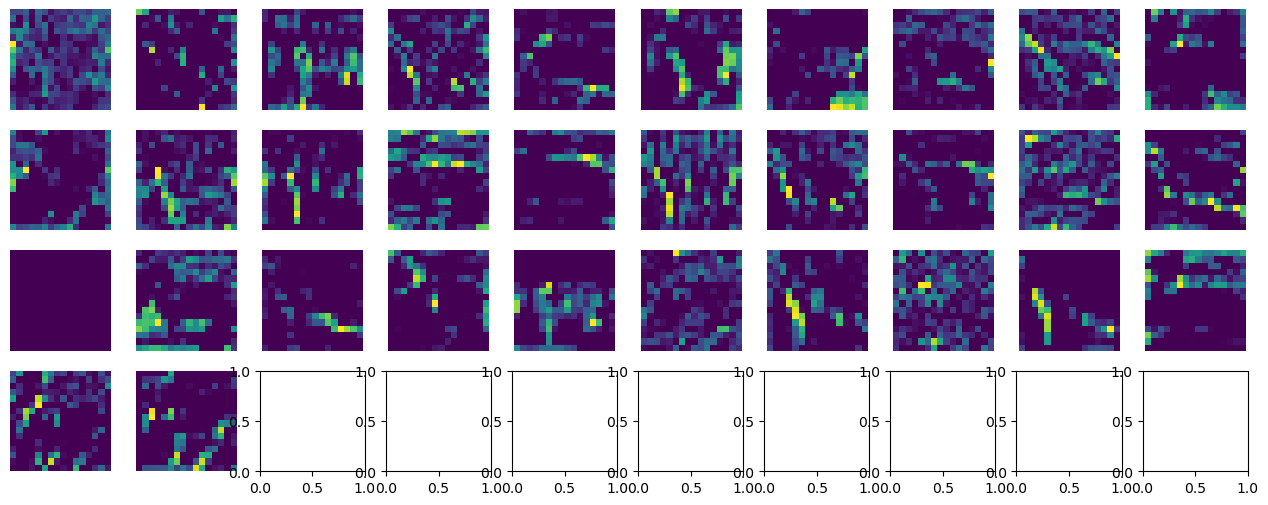

----------------------------------------------------------------------------------------------------
Activations layer 5 - conv2d_7


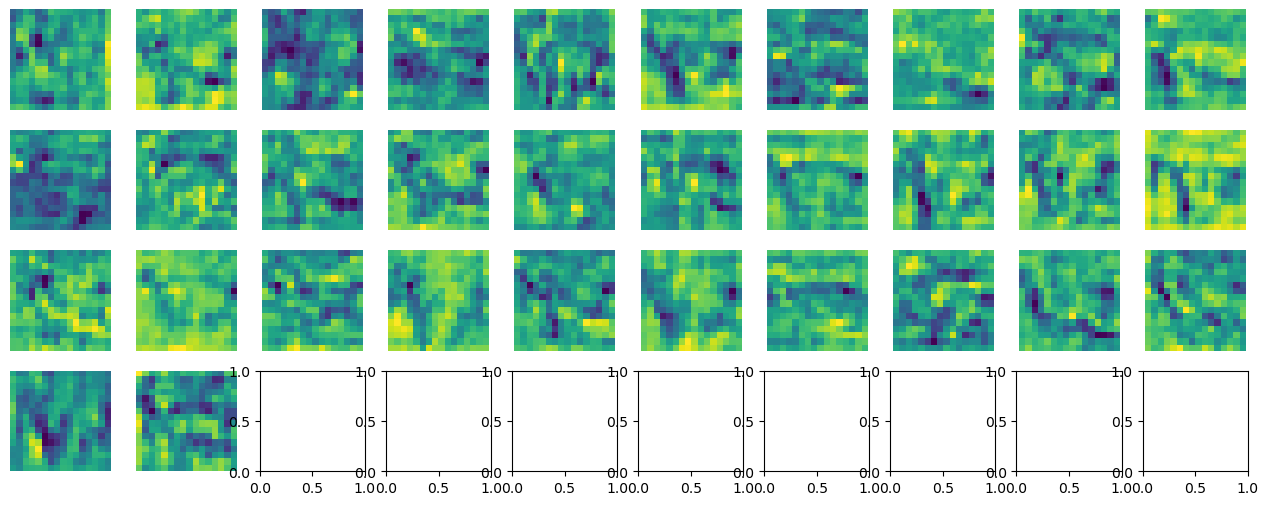

----------------------------------------------------------------------------------------------------
Activations layer 6 - activation_4


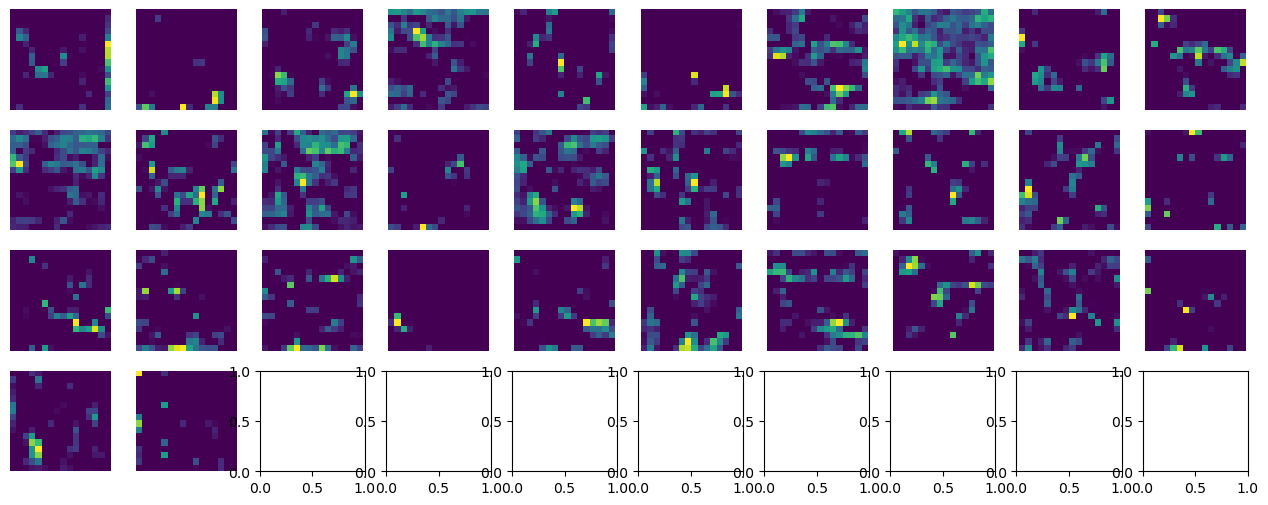

----------------------------------------------------------------------------------------------------
Skip printing activations for layer type <class 'keras.layers.core.flatten.Flatten'>
----------------------------------------------------------------------------------------------------
Skip printing activations for layer type <class 'keras.layers.core.dense.Dense'>
----------------------------------------------------------------------------------------------------


In [32]:
#Test image
test_img = X_test[12]
plt.imshow(test_img)
plt.show()
test_img = test_img.reshape(1, 32, 32, 3)

for idx, layer in enumerate(cnn.layers):
    print("-"*100)
    if idx == 9:
        break
    if type(layer) in [keras.layers.Conv2D, keras.layers.MaxPooling2D, keras.layers.Activation]:
        print(f"Activations layer {idx} - {layer.name}")
        outputs = cnn.layers[idx].output
        plot_activations(outputs=outputs, base_model=cnn, test_img=test_img)
    else:
        print(f"Skip printing activations for layer type {type(layer)}")